In [1]:
import pandas as pd
import sys,os
import random

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, '../..')

from unpast.utils.io import read_bic_table
from unpast.utils.method import zscore
from unpast.utils.eval import calculate_perfromance

In [2]:
bic_path = "../../../outputs/"
data_path = "../../data/asthma/"
img_path = "../../../img/Fig3/"

### Reading annotation and expression,
prepareing inputs for calculate_perfromance()

In [3]:
exprs_file = data_path+"/asthma_GSE4302.RMA.maxRowVariance.log2exprs.tsv.gz"
exprs = pd.read_csv(exprs_file, sep="\t",index_col=0)

anno  = pd.read_csv(data_path+"/asthma_GSE4302.annot.tsv.gz",sep="\t",index_col=0)
anno.head(3)
all_samples = set(exprs.columns).intersection(set(anno.index))

In [4]:
# genes x samples
exprs.shape

(18317, 118)

In [5]:
# samples with Th2 signature
known_groups = {"Th2 asthma":{"Th2-high": set(anno.loc[anno["Th2 asthma"]==1,:].index.values)}}
len(known_groups["Th2 asthma"]["Th2-high"] )

37

### UnPaSt results

In [6]:
unpast_biclusters = read_bic_table(bic_path+"/GSE4302/UnPaSt/optimized_ARI/asthma_GSE4302.seed=42.kmeans.consensus.biclsuters.tsv")

performance, best_matches = calculate_perfromance(unpast_biclusters, 
                                                  known_groups, 
                                                  all_samples, 
                                                  adjust_pvals = "BH",
                                                  performance_measure = "ARI")
print("Performance:",performance[0])
best_matches

Performance: 0.8650702286636647


,ARI,adj_pval,bm_id,is_enriched,n_samples,samples,weight,classification
Th2-high,0.86507,0.000017,20,True,35,"{GSM98195, GSM98145, GSM98215, GSM98150, GSM98...",1.0,Th2 asthma


In [7]:
bm_id = best_matches.loc[:,"bm_id"][0]
genes = unpast_biclusters.loc[bm_id,"genes"]
bm_id

20

<Figure size 432x288 with 0 Axes>

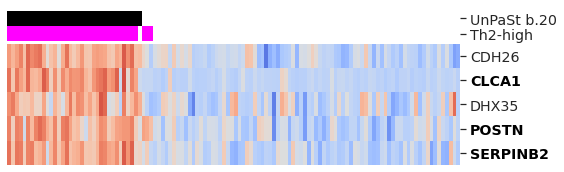

In [8]:
from unpast.utils.figs import draw_heatmap2
from collections import OrderedDict

a = anno.loc[:,["asthma","sample type:ch1","Th2 asthma"]]
a.loc[a["asthma"]==1,"asthma"] = "Asthma"
a.loc[a["asthma"]==0,"asthma"] = "Healthy"

a = a.loc[:,["Th2 asthma"]]
a.columns = ["Th2-high"]
a.loc[a["Th2-high"]==1,"Th2-high"] = "Th2-high"
a.loc[a["Th2-high"]==0,"Th2-high"] = "Th2-low"

sns.set(font_scale=1.3)
# selecting colors
color_dict = OrderedDict()

color_dict["Th2-high"] = OrderedDict()
color_dict["Th2-high"]["Th2-high"] = "magenta"
color_dict["Th2-high"]["Th2-low"] = "white"

plt.figure()
sns_plot,col_order,(row_colors, col_colors) = draw_heatmap2(exprs.loc[sorted(genes),:],
                                                            unpast_biclusters.loc[[bm_id],:],
                 annot=a,
                 color_dict=color_dict,
                 figsize = (8,2.5),
                 dendrogram_ratio=(0.01,0.01),
                 colors_ratio=(0,0.1),
                 legend_n_cols=0,
                 no_cbar=True,
                 cluster_rows=False,
                 xlabel = "",
                 col_labels = False,
                 row_labels = True,
                 highlight_row_labels=["POSTN","CLCA1","SERPINB2"],
                 #col_range=(-3,3),
                 bic_prefix = "UnPaSt b.")
tmp = sns_plot.ax_heatmap.set_yticklabels(sns_plot.ax_heatmap.get_yticklabels(), rotation=0)
#tmp = sns_plot.fig.suptitle('GSE4302, UnPaSt') 

fig_name = "Fig3_E_GSE4302_UnPaSt"
for ext in ["pdf","svg"]:
    plt.savefig(img_path+"/"+fig_name+"."+ext, dpi=300, transparent=True)

In [9]:
cseed = 42
n_runs = 5
seeds = []
random.seed(cseed)
p = []
for i in range(n_runs):
    seeds.append(random.randint(0,1000000))
    seed = seeds[i]
    fname = "asthma_GSE4302.seed="+str(seed)+".bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv"
    unpast_biclusters = read_bic_table(bic_path+"/GSE4302/UnPaSt/optimized_ARI/"+fname)
    #unpast_biclusters = read_bic_table(unpast_bic_path+fname)
    
    performance, best_matches = calculate_perfromance(unpast_biclusters, 
                                                      known_groups,
                                                      set(anno.index.values),
                                                      adjust_pvals="BH",
                                                      performance_measure="ARI")
    bm_id = best_matches["bm_id"].values[0]
    p.append(performance[0])
    print("\t".join([str(seed),str(round(performance[0],2)),
                     " ".join(sorted(unpast_biclusters.loc[bm_id,"genes"]))
                    ]))


print("average in %s runs: %.2f"%(n_runs, sum(p)/n_runs))

670487	0.5	CCL26 CD1C CD274 CDH26 CEACAM1 CLC CLCA1 CST1 CST2 CST4 DHX35 ITLN1 P2RY14 POSTN SERPINB10 SERPINB2 UTP20 ZMAT4
116739	0.59	CCL26 CLC CLCA1 CST1 CST2 CST4 DHX35 ITLN1 MS4A2 P2RY14 POSTN SERPINB10 SERPINB2 UTP20 ZMAT4
26225	0.87	CDH26 CLCA1 DHX35 POSTN SERPINB2
777572	0.87	CDH26 CLCA1 DHX35 POSTN SERPINB2
288389	0.87	CDH26 DHX35 POSTN SERPINB2
average in 5 runs: 0.74


####  plot legend  

<Figure size 432x288 with 0 Axes>

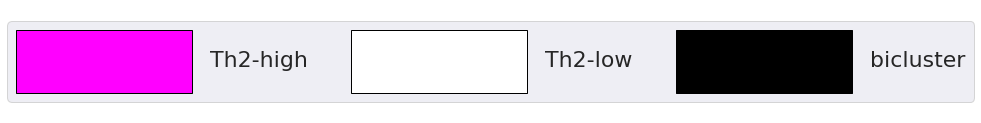

In [10]:
from matplotlib.patches import Patch
sns.set()

plt.figure()
legend_elements = []

for subt in color_dict["Th2-high"].keys():
    p = Patch(facecolor=color_dict["Th2-high"][subt], edgecolor='black', label=subt)
    legend_elements.append(p)
    
p = Patch(facecolor="black", edgecolor='black', label="bicluster")
legend_elements.append(p)

# Create the figure
fig, ax = plt.subplots(figsize = (10,2))
ax.legend(handles=legend_elements, loc='center',ncol = 3,handlelength=8, 
          handleheight=4, title = '', prop={'size': 22})

ax.axis('off')
fig_name = "Fig3_E_legend"
plt.savefig(img_path+"/"+fig_name+".png", dpi=300, transparent=True)
plt.savefig(img_path+"/"+fig_name+".svg", transparent=True)
plt.show()

### QUBIC results

In [11]:
qubic_biclusters = pd.read_csv(bic_path+"/GSE4302/QUBIC/optimized_ARI/GSE4302_r=1-q=0.04-c=0.75-f=1-type=area-biclusters_df.tsv",sep = "\t",index_col=0)
qubic_biclusters['genes'] = qubic_biclusters['genes'].apply(lambda row: eval(row))
qubic_biclusters['samples'] = qubic_biclusters['samples'].apply(lambda row: eval(row))
qubic_biclusters.head(3)

,samples,genes
0,"{GSM98195, GSM98179, GSM98220, GSM98147, GSM98...","{AHCYL1, CT75, OTUD1, LINC00466, LRRC4C, ARHGA..."
1,"{GSM98195, GSM98179, GSM98220, GSM98147, GSM98...","{CT75, OTUD1, LINC00466, ARHGAP26, P2RY6, COX1..."
2,"{GSM98195, GSM98179, GSM98220, GSM98147, GSM98...","{CT75, LINC00466, LRRC4C, ARHGAP26, RNF150, CF..."


In [12]:
performance, best_matches = calculate_perfromance(qubic_biclusters, 
                                                  known_groups, 
                                                  all_samples,
                                                  adjust_pvals="BH",
                                                  performance_measure = "ARI")
print("Performance:",performance[0])
best_matches

Performance: 0.39593680183872576


,ARI,adj_pval,bm_id,is_enriched,n_samples,samples,weight,classification
Th2-high,0.395937,0.000052,615,True,19,"{GSM98195, GSM98145, GSM98215, GSM98150, GSM98...",1.0,Th2 asthma


In [13]:
bm_id = best_matches.loc[:,"bm_id"][0]
qubic_biclusters['genes_up'] = qubic_biclusters["genes"]
qubic_biclusters['genes_down'] = [set([])]*qubic_biclusters.shape[0]
genes = qubic_biclusters.loc[bm_id,"genes"]

bm_id

615

<Figure size 432x288 with 0 Axes>

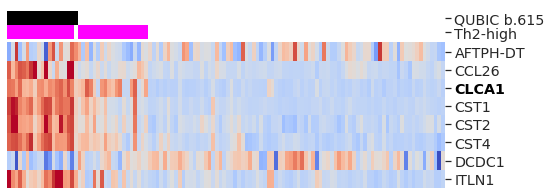

In [14]:
a = anno.loc[:,["asthma","sample type:ch1","Th2 asthma"]]
a.loc[a["asthma"]==1,"asthma"] = "Asthma"
a.loc[a["asthma"]==0,"asthma"] = "Healthy"

a = a.loc[:,["Th2 asthma"]]
a.columns = ["Th2-high"]
a.loc[a["Th2-high"]==1,"Th2-high"] = "Th2-high"
a.loc[a["Th2-high"]==0,"Th2-high"] = "Th2-low"

sns.set(font_scale=1.3)
# selecting colors
color_dict = OrderedDict()

color_dict["Th2-high"] = OrderedDict()
color_dict["Th2-high"]["Th2-high"] = "magenta"
color_dict["Th2-high"]["Th2-low"] = "white"

plt.figure()
sns_plot,col_order,(row_colors, col_colors) = draw_heatmap2(exprs.loc[sorted(genes),:],
                                                            qubic_biclusters.loc[[bm_id],:],
                 annot=a,
                 color_dict=color_dict,
                 figsize = (8,3),
                 dendrogram_ratio=(0.01,0.01),
                 colors_ratio=(0,0.08),
                 legend_n_cols=0,no_cbar=True,
                 cluster_rows=False,
                 xlabel = "",
                 col_labels = False,row_labels = True,
                 highlight_row_labels=["POSTN","CLCA1","SERPINB2"],
                 bic_prefix = "QUBIC b.")
tmp = sns_plot.ax_heatmap.set_yticklabels(sns_plot.ax_heatmap.get_yticklabels(), rotation=0)
#tmp = sns_plot.fig.suptitle('GSE4302, QUBIC (optimized)')
fig_name = "Fig3_X_GSE4302_QUBIC_opt"
for ext in ["pdf","svg"]:
    plt.savefig(img_path+"/"+fig_name+"."+ext, dpi=300, transparent=True)

# GSE89809 
### UnPaSt

In [15]:
exprs_file = data_path + "/asthma_GSE89809_epithelial.RMA.maxRowVariance.log2exprs.tsv.gz"
exprs = pd.read_csv(exprs_file, sep="\t",index_col=0)

anno  = pd.read_csv(data_path+"/asthma_GSE89809_epithelial.annot.tsv.gz",sep="\t",index_col=0)

known_groups = {"Th2 asthma":{"Th2-high": set(anno.loc[anno["Th2 asthma"]==1,:].index.values)}}

In [16]:
exprs.shape

(18311, 56)

In [17]:
unpast_biclusters = read_bic_table(bic_path+"GSE89809/UnPaSt/optimized_ARI/asthma_GSE89809.seed=42.kmeans.consensus.biclsuters.tsv")

performance, best_matches = calculate_perfromance(unpast_biclusters, 
                                                  known_groups, 
                                                  set(anno.index.values),
                                                  adjust_pvals="BH",
                                                  performance_measure = "ARI")
print("Performance:",performance[0])
best_matches


Performance: 0.7831907772406099


,ARI,adj_pval,bm_id,is_enriched,n_samples,samples,weight,classification
Th2-high,0.783191,0.000006,52,True,14,"{GSM2389885, GSM2389926, GSM2389886, GSM238989...",1.0,Th2 asthma


In [18]:
bm_id = best_matches.loc[:,"bm_id"][0]
genes = unpast_biclusters.loc[bm_id,"genes"]
bm_id

52

<Figure size 432x288 with 0 Axes>

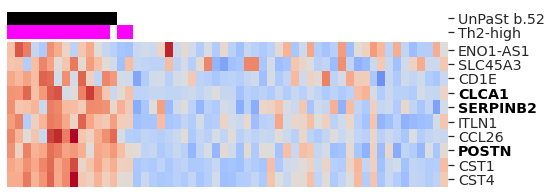

In [19]:
sns.set(font_scale=1.3)
a = anno.loc[:,["Th2 asthma"]]
a.columns = ["Th2-high"]
a.loc[a["Th2-high"]==1,"Th2-high"] = "Th2-high"
a.loc[a["Th2-high"]==0,"Th2-high"] = "Th2-low"

# selecting colors
color_dict = OrderedDict()

color_dict["Th2-high"] = OrderedDict()
color_dict["Th2-high"]["Th2-high"] = "magenta"
color_dict["Th2-high"]["Th2-low"] = "white"

plt.figure()
sns_plot,col_order,(row_colors, col_colors) = draw_heatmap2(zscore(exprs),
                                                            unpast_biclusters.loc[[bm_id],:],
                 annot=a,
                 color_dict=color_dict,
                 figsize = (8,3),
                 dendrogram_ratio=(0.01,0.01),
                 colors_ratio=(0,0.08),
                 legend_n_cols=0,
                 no_cbar=True,
                 cluster_rows=True,
                 xlabel = "",
                 col_labels = False,row_labels = True,
                 bic_prefix = "UnPaSt b.",
                 highlight_row_labels=["POSTN","CLCA1","SERPINB2"],)
tmp = sns_plot.ax_heatmap.set_yticklabels(sns_plot.ax_heatmap.get_yticklabels(), rotation=0)
#tmp = sns_plot.fig.suptitle('GSE89809, UnPaSt') 
fig_name = "Fig3_x_GSE89809_UnPaSt"
for ext in ["pdf","svg"]:
    plt.savefig(img_path+"/"+fig_name+"."+ext, dpi=300, transparent=True)

In [20]:
bm_id = best_matches["bm_id"].values[0]
" ".join(sorted(unpast_biclusters.loc[bm_id,"genes"]))

'CCL26 CD1E CLCA1 CST1 CST4 ENO1-AS1 ITLN1 POSTN SERPINB2 SLC45A3'

In [21]:
" ".join(sorted(unpast_biclusters.loc[bm_id,"samples"]))

'GSM2389883 GSM2389885 GSM2389886 GSM2389888 GSM2389890 GSM2389891 GSM2389892 GSM2389893 GSM2389894 GSM2389919 GSM2389921 GSM2389923 GSM2389926 GSM2389927'

In [22]:
cseed = 42
n_runs = 5
seeds = []
random.seed(cseed)
p = []
for i in range(n_runs):
    seeds.append(random.randint(0,1000000))
    seed = seeds[i]
    fname = "asthma_GSE89809.seed="+str(seed)+".bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv"
    unpast_biclusters = read_bic_table(bic_path+"/GSE89809/UnPaSt/optimized_ARI/"+fname)
    
    
    performance, best_matches = calculate_perfromance(unpast_biclusters, 
                                                      known_groups, 
                                                      set(anno.index.values),
                                                      adjust_pvals="BH",
                                                      performance_measure = "ARI")
    bm_id = best_matches["bm_id"].values[0]
    p.append(performance[0])
    print("\t".join([str(seed),str(round(performance[0],2)),
                     " ".join(sorted(unpast_biclusters.loc[bm_id,"genes"]))
                    ]))


print("average in %s runs: %.2f"%(n_runs, sum(p)/n_runs))

670487	0.72	CCL26 LINC01504 POSTN SERPINB2
116739	0.72	CCL26 CST1 CST4 POSTN SERPINB2
26225	0.59	CD1E CLCA1 ENO1-AS1 KRIT1
777572	0.78	CACNB4 CCL26 CLCA1 POSTN
288389	0.79	CLCA1 CST1 ITLN1 SLC45A3
average in 5 runs: 0.72


### QUBIC

In [23]:
qubic_biclusters = pd.read_csv(bic_path+"/GSE89809/QUBIC/optimized_ARI/GSE89809_r=1-q=0.04-c=0.75-f=1-type=area-biclusters_df.tsv",sep = "\t",index_col=0)
qubic_biclusters['genes'] = qubic_biclusters['genes'].apply(lambda row: eval(row))
qubic_biclusters['samples'] = qubic_biclusters['samples'].apply(lambda row: eval(row))
qubic_biclusters['n_samples'] = qubic_biclusters['samples'].apply(lambda x: len(x)) 
qubic_biclusters = qubic_biclusters.loc[qubic_biclusters["n_samples"] > 5, :]
qubic_biclusters.head(3)

,samples,genes,n_samples
1,"{GSM2389931, GSM2389890, GSM2389840, GSM238995...","{AHCYL1, CLU, MEF2A, CNPY2, UCN, TMBIM6, AIMP2...",7
4,"{GSM2389931, GSM2389840, GSM2389953, GSM238993...","{USP44, AHCYL1, CLU, MEF2A, CNPY2, UCN, RSPH6A...",6
5,"{GSM2389852, GSM2389931, GSM2389849, GSM238988...","{USP44, NECAP1, RFTN2, RSPH6A, RPL10P10, KL, S...",6


In [24]:
performance, best_matches2 = calculate_perfromance(qubic_biclusters,
                                                   known_groups, 
                                                   set(anno.index.values),
                                                   adjust_pvals="BH",
                                                   performance_measure = "ARI"
                                                  )
print("Performance:",performance[0])
best_matches2

Performance: 0.7089455272363818


,ARI,adj_pval,bm_id,is_enriched,n_samples,samples,weight,classification
Th2-high,0.708946,0.000013,62,True,11,"{GSM2389885, GSM2389888, GSM2389886, GSM238989...",1.0,Th2 asthma


In [25]:
bm_id = best_matches2["bm_id"].values[0]
" ".join(sorted(qubic_biclusters.loc[bm_id,"samples"]))

'GSM2389883 GSM2389885 GSM2389886 GSM2389888 GSM2389891 GSM2389893 GSM2389894 GSM2389919 GSM2389923 GSM2389926 GSM2389927'

In [26]:
" ".join(sorted(qubic_biclusters.loc[bm_id,"genes"]))

'CCL26 CLCA1 CST1 CST2 CST4 NOS2 SERPINB10'

In [27]:
bm_id = best_matches2.loc[:,"bm_id"][0]
qubic_biclusters['genes_up'] = qubic_biclusters["genes"]
qubic_biclusters['genes_down'] = [set([])]*qubic_biclusters.shape[0]
genes = qubic_biclusters.loc[bm_id,"genes"]

bm_id

62

<Figure size 432x288 with 0 Axes>

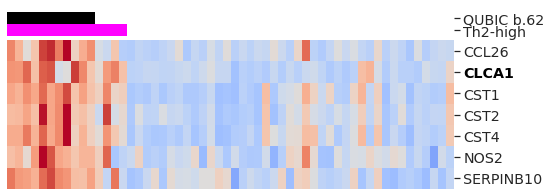

In [28]:
a = anno.loc[:,["Th2 asthma"]]
a.columns = ["Th2-high"]
a.loc[a["Th2-high"]==1,"Th2-high"] = "Th2-high"
a.loc[a["Th2-high"]==0,"Th2-high"] = "Th2-low"

# selecting colors
color_dict = OrderedDict()

color_dict["Th2-high"] = OrderedDict()
color_dict["Th2-high"]["Th2-high"] = "magenta"
color_dict["Th2-high"]["Th2-low"] = "white"

plt.figure()
sns_plot,col_order,(row_colors, col_colors) = draw_heatmap2(zscore(exprs),
                                                            qubic_biclusters.loc[[bm_id],:],
                 annot=a,
                 color_dict=color_dict,
                 figsize = (8,3),
                 dendrogram_ratio=(0.01,0.01),
                 colors_ratio=(0,0.07),
                 legend_n_cols=0,
                 no_cbar=True,
                 cluster_rows=False,
                 xlabel = "",
                 col_labels = False,row_labels = True,
                 highlight_row_labels=["POSTN","CLCA1","SERPINB2"],
                 bic_prefix = "QUBIC b.")
tmp = sns_plot.ax_heatmap.set_yticklabels(sns_plot.ax_heatmap.get_yticklabels(), rotation=0)
#tmp = sns_plot.fig.suptitle('GSE89809, QUBIC (optimized)')
fig_name = "Fig3_x_GSE89809_QUBIC_opt"
for ext in ["pdf","svg"]:
    plt.savefig(img_path+"/"+fig_name+"."+ext, dpi=300, transparent=True)

# All methods
### GSE4302

In [29]:
exprs_file = data_path+"/asthma_GSE4302.RMA.maxRowVariance.log2exprs.tsv.gz"
exprs = pd.read_csv(exprs_file, sep="\t",index_col=0)

anno  = pd.read_csv(data_path+"/asthma_GSE4302.annot.tsv.gz",sep="\t",index_col=0)

known_groups = {"Th2 asthma":{"Th2-high": set(anno.loc[anno["Th2 asthma"]==1,:].index.values)}}

all_samples = set(exprs.columns).intersection(set(anno.index))
print(len(all_samples))

118


In [30]:
from pandas.errors import EmptyDataError

stats1 = []
ds = "GSE4302"
fpath = bic_path+ds+"/"
for params  in ["optimized_ARI" ,"default"]:
    for method in os.listdir(fpath):
        for f in os.listdir(fpath+method+"/"+params+"/"):
            if not "consensus" in f:
                try:
                    df_clusters = pd.read_csv(fpath+method+"/"+params+"/"+f,sep="\t",index_col=0,comment="#")
                except EmptyDataError:
                    #print("empty",f,"0 biclusters")
                    df_clusters =pd.DataFrame(columns=["samples","n_samples"])
                if df_clusters.shape[0]>0 and not type(df_clusters["samples"].values[0])==set:
                    df_clusters["samples"] = df_clusters["samples"].apply(lambda row: set([ x.replace(",","").replace("'","").replace('"','') for x in row.replace("{","").replace("}","").split(" ") if len(x)>0])) 
                if not "n_samples" in df_clusters.columns:
                    df_clusters["n_samples"] = df_clusters["samples"].apply(lambda x: len(x))
                df_clusters = df_clusters.loc[df_clusters["n_samples"] >= 5,:]
                df_clusters = df_clusters.loc[df_clusters["n_samples"] <= len(all_samples)-5,:]

                if df_clusters.shape[0]>0:
                    performance, best_matches = calculate_perfromance(df_clusters,
                                                                      known_groups,
                                                                      all_samples, 
                                                                      adjust_pvals = "BH",
                                                                      performance_measure = "ARI")
                    ari = performance["Th2 asthma"]
                    stats1.append({"method":method,
                                  "dataset":ds,
                                  "parameters":params,
                                  "ARI":ari,
                                  "file":fpath+method+"/"+params+"/"+f})
                else:
                    #print(method,params,"0 clusters")
                    stats1.append({"method":method,
                                  "dataset":ds,
                                  "parameters":params,
                                  "file":fpath+method+"/"+params+"/"+f})

stats1 = pd.DataFrame.from_records(stats1).fillna(0)
stats1.sort_values("ARI",ascending =False).head(10)

,method,dataset,parameters,ARI,file
26,UnPaSt,GSE4302,optimized_ARI,0.865552,../../outputs/GSE4302/UnPaSt/optimized_ARI/ast...
24,UnPaSt,GSE4302,optimized_ARI,0.865070,../../outputs/GSE4302/UnPaSt/optimized_ARI/ast...
25,UnPaSt,GSE4302,optimized_ARI,0.865070,../../outputs/GSE4302/UnPaSt/optimized_ARI/ast...
22,UnPaSt,GSE4302,optimized_ARI,0.585620,../../outputs/GSE4302/UnPaSt/optimized_ARI/ast...
23,UnPaSt,GSE4302,optimized_ARI,0.500189,../../outputs/GSE4302/UnPaSt/optimized_ARI/ast...
97,ISA2,GSE4302,default,0.418372,../../outputs/GSE4302/ISA2/default/GSE4302_no_...
14,ISA2,GSE4302,optimized_ARI,0.418372,../../outputs/GSE4302/ISA2/optimized_ARI/GSE43...
10,ISA2,GSE4302,optimized_ARI,0.418372,../../outputs/GSE4302/ISA2/optimized_ARI/GSE43...
12,ISA2,GSE4302,optimized_ARI,0.418372,../../outputs/GSE4302/ISA2/optimized_ARI/GSE43...
93,ISA2,GSE4302,default,0.418372,../../outputs/GSE4302/ISA2/default/GSE4302_no_...


# GSE89809


In [31]:
exprs_file = data_path+"/asthma_GSE89809_epithelial.RMA.maxRowVariance.log2exprs.tsv.gz"
exprs = pd.read_csv(exprs_file, sep="\t",index_col=0)

anno  = pd.read_csv(data_path+"/asthma_GSE89809_epithelial.annot.tsv.gz",sep="\t",index_col=0)
anno.head(3)

known_groups = {"Th2 asthma":{"Th2-high": set(anno.loc[anno["Th2 asthma"]==1,:].index.values)}}
known_groups["Th2 asthma"].keys()
all_samples = set(exprs.columns).intersection(set(anno.index))
print(len(all_samples))

56


In [32]:
from pandas.errors import EmptyDataError

stats2 = []
ds = "GSE89809"
fpath = bic_path+ds+"/"
for params  in ["optimized_ARI" ,"default"]:
    for method in os.listdir(fpath):
        for f in os.listdir(fpath+method+"/"+params+"/"):
            if not "consensus" in f:
                try:
                    df_clusters = pd.read_csv(fpath+method+"/"+params+"/"+f,sep="\t",index_col=0,comment="#")
                except EmptyDataError:
                    #print("empty",f,"0 biclusters")
                    df_clusters =pd.DataFrame(columns=["samples","n_samples"])
                if df_clusters.shape[0]>0 and not type(df_clusters["samples"].values[0])==set:
                    df_clusters["samples"] = df_clusters["samples"].apply(lambda row: set([ x.replace(",","").replace("'","").replace('"','') for x in row.replace("{","").replace("}","").split(" ") if len(x)>0])) 
                if not "n_samples" in df_clusters.columns:
                    df_clusters["n_samples"] = df_clusters["samples"].apply(lambda x: len(x))
                df_clusters = df_clusters.loc[df_clusters["n_samples"] >= 5,:]
                df_clusters = df_clusters.loc[df_clusters["n_samples"] <= len(all_samples)-5,:]

                if df_clusters.shape[0]>0:
                    performance, best_matches = calculate_perfromance(df_clusters,
                                                                      known_groups,
                                                                      all_samples, 
                                                                      adjust_pvals = "BH",
                                                                      performance_measure = "ARI")
                    #print(best_matches)
                    ari = performance["Th2 asthma"]
                    stats2.append({"method":method,
                                  "dataset":ds,
                                  "parameters":params,
                                  "ARI":ari,
                                  "file":fpath+method+"/"+params+"/"+f})
                else:
                    #print(method,params,"0 clusters")
                    stats2.append({"method":method,
                                  "dataset":ds,
                                  "parameters":params,
                                  "file":fpath+method+"/"+params+"/"+f})

stats2 = pd.DataFrame.from_records(stats2).fillna(0)
stats2.sort_values("ARI",ascending =False).head(10)

,method,dataset,parameters,ARI,file
30,UnPaSt,GSE89809,optimized_ARI,0.786242,../../outputs/GSE89809/UnPaSt/optimized_ARI/as...
31,UnPaSt,GSE89809,optimized_ARI,0.783191,../../outputs/GSE89809/UnPaSt/optimized_ARI/as...
27,UnPaSt,GSE89809,optimized_ARI,0.722096,../../outputs/GSE89809/UnPaSt/optimized_ARI/as...
29,UnPaSt,GSE89809,optimized_ARI,0.718462,../../outputs/GSE89809/UnPaSt/optimized_ARI/as...
59,QUBIC,GSE89809,optimized_ARI,0.708946,../../outputs/GSE89809/QUBIC/optimized_ARI/GSE...
28,UnPaSt,GSE89809,optimized_ARI,0.587644,../../outputs/GSE89809/UnPaSt/optimized_ARI/as...
120,AP,GSE89809,default,0.112848,../../outputs/GSE89809/AP/default/GSE89809.Aff...
119,AP,GSE89809,default,0.112848,../../outputs/GSE89809/AP/default/GSE89809.Aff...
118,AP,GSE89809,default,0.112848,../../outputs/GSE89809/AP/default/GSE89809.Aff...
117,AP,GSE89809,default,0.112848,../../outputs/GSE89809/AP/default/GSE89809.Aff...


In [33]:
stats = pd.concat([stats1,stats2]).sort_values("ARI",ascending = False)
stats.loc[stats["parameters"]=="optimized_ARI","parameters"] = "optimized"
stats.to_csv("../unpast_results/asthma_performances_Fig3_v4.tsv.gz",sep ="\t")
stats.head(15)

,method,dataset,parameters,ARI,file
26,UnPaSt,GSE4302,optimized,0.865552,../../outputs/GSE4302/UnPaSt/optimized_ARI/ast...
25,UnPaSt,GSE4302,optimized,0.865070,../../outputs/GSE4302/UnPaSt/optimized_ARI/ast...
24,UnPaSt,GSE4302,optimized,0.865070,../../outputs/GSE4302/UnPaSt/optimized_ARI/ast...
30,UnPaSt,GSE89809,optimized,0.786242,../../outputs/GSE89809/UnPaSt/optimized_ARI/as...
31,UnPaSt,GSE89809,optimized,0.783191,../../outputs/GSE89809/UnPaSt/optimized_ARI/as...
27,UnPaSt,GSE89809,optimized,0.722096,../../outputs/GSE89809/UnPaSt/optimized_ARI/as...
29,UnPaSt,GSE89809,optimized,0.718462,../../outputs/GSE89809/UnPaSt/optimized_ARI/as...
59,QUBIC,GSE89809,optimized,0.708946,../../outputs/GSE89809/QUBIC/optimized_ARI/GSE...
28,UnPaSt,GSE89809,optimized,0.587644,../../outputs/GSE89809/UnPaSt/optimized_ARI/as...
22,UnPaSt,GSE4302,optimized,0.585620,../../outputs/GSE4302/UnPaSt/optimized_ARI/ast...


### plots

In [34]:
palette = ["#ff0000","#de8f05","#de8f05","#de8f05","#0173b2","#0173b2","#0173b2"]

<ipython-input-35-d5c3822e8876>:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for bars, hatch, legend_handle in zip(sns_plot2.containers, ['', '//'], sns_plot2.legend_.legendHandles):


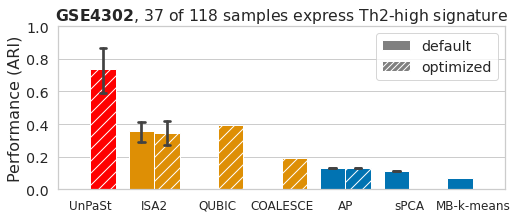

In [35]:
figsizes = (8,3)
#sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
#sns.set()
sns.set_style("whitegrid")

plt.figure(figsize=figsizes)
df = stats.loc[stats['dataset']=="GSE4302",:]
df = df.loc[df["ARI"]>0,:]
sns_plot2 = sns.barplot(data=df, 
                        x="method",y="ARI", hue="parameters",
                         capsize=0.1, 
            hue_order=['default', 'optimized'],palette=["grey"]*5)

#sns_plot2.legend_.remove()
plt.legend(loc='upper right')
# Set plot title and labels
plt.title('$\mathbf{{GSE4302}}$, 37 of 118 samples express Th2-high signature')
plt.ylim(0,1)
tmp = plt.ylabel('Performance (ARI)', fontsize=16)
tmp = plt.xlabel('')
tmp = plt.xticks(fontsize=12)

# sub_fig is the returned ax and palette is a list of colors for each element on the x-axis
for bars, hatch, legend_handle in zip(sns_plot2.containers, ['', '//'], sns_plot2.legend_.legendHandles):
    for bar, color in zip(bars, palette):
        bar.set_facecolor(color)
        bar.set_hatch(hatch)
    # update the existing legend, use twice the hatching pattern to make it denser
    #legend_handle.set_color("grey")
    legend_handle.set_hatch(hatch+hatch)
    
fig_name = "Fig3_x_GSE4302"
for ext in ["pdf","svg"]:
    plt.savefig(img_path+"/"+fig_name+"."+ext, dpi=300, transparent=True)

<ipython-input-36-dcfb35721ef8>:17: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for bars, hatch, legend_handle in zip(sns_plot1.containers, ['', '//'], sns_plot1.legend_.legendHandles):


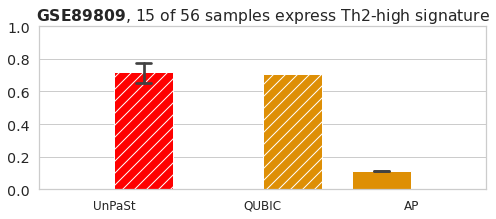

In [36]:
plt.figure(figsize=figsizes)

df = stats.loc[stats['dataset']=="GSE89809",:]
df = df.loc[df["ARI"]>0,:]
sns_plot1 = sns.barplot(data=df, 
                        x="method",y="ARI", hue="parameters",
                         capsize=0.1, 
            hue_order=['default', 'optimized'],palette=["grey"]*5)
# Set plot title and labels
plt.ylim(0,1)
plt.title('$\mathbf{{GSE89809}}$, 15 of 56 samples express Th2-high signature')
plt.ylabel('')
tmp = plt.xlabel('')
tmp = plt.xticks(fontsize=12)

# sub_fig is the returned ax and palette is a list of colors for each element on the x-axis
for bars, hatch, legend_handle in zip(sns_plot1.containers, ['', '//'], sns_plot1.legend_.legendHandles):
    for bar, color in zip(bars, palette):
        bar.set_facecolor(color)
        bar.set_hatch(hatch)
    # update the existing legend, use twice the hatching pattern to make it denser
    #legend_handle.set_color("grey")
    legend_handle.set_hatch(hatch+hatch)
    
sns_plot1.legend_.remove()
fig_name = "Fig3_x_GSE489809"
for ext in ["pdf","svg"]:
    plt.savefig(img_path+"/"+fig_name+"."+ext, dpi=300, transparent=True)

# UnPaSt - sex specific biclusters

In [37]:
exprs_file = data_path+"asthma_GSE4302.RMA.maxRowVariance.log2exprs.tsv.gz"
exprs = pd.read_csv(exprs_file, sep="\t",index_col=0)

anno  = pd.read_csv(data_path+"asthma_GSE4302.annot.tsv.gz",sep="\t",index_col=0)
anno.head(3)
all_samples = set(exprs.columns).intersection(set(anno.index))

bics1 = read_bic_table(bic_path+"GSE4302/UnPaSt/optimized_ARI/asthma_GSE4302.seed=42.kmeans.consensus.biclsuters.tsv")

In [38]:
# sex-specific 
bics1[bics1["genes"].apply(lambda x: "KDM5D" in x)]

,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids
id,,,,,,,,,,,,
0,7.693274,8,58,"{UTY, DDX3Y, KDM5D, ARSL, TTTY14, RPS4Y1, ZFY,...","{GSM98195, GSM98179, GSM98220, GSM98147, GSM98...","{UTY, DDX3Y, KDM5D, ARSL, TTTY14, RPS4Y1, ZFY,...",{},"{7521, 3781, 17737, 16813, 1006, 13549, 4440, ...","{6, 7, 16, 17, 22, 23, 26, 27, 28, 29, 30, 31,...",UP,5,seed=116739_0 seed=26225_0 seed=288389_0 seed=...


In [39]:
# smoking
bics1[bics1["genes"].apply(lambda x: "GPX2" in x)]

,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids
id,,,,,,,,,,,,
3,3.045353,20,14,"{UCHL1, AKR1B10, LINC00942, NRCAM, GPX2, JAKMI...","{GSM98249, GSM98237, GSM98256, GSM98250, GSM98...","{UCHL1, AKR1B10, LINC00942, NRCAM, GPX2, JAKMI...",{},"{10756, 517, 7318, 13722, 11684, 10789, 8488, ...","{96, 97, 64, 105, 106, 107, 108, 109, 114, 115...",UP,9,seed=116739_1 seed=26225_4 seed=26225_7 seed=2...


In [40]:
# Th2-high signature
bics1[bics1["genes"].apply(lambda x: "CLCA1" in x)]

,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids
id,,,,,,,,,,,,
14,2.214532,17,20,"{ITLN1, TIMM8A, CCL26, CLCA1, P2RY14, CST1, UT...","{GSM98195, GSM98145, GSM98215, GSM98150, GSM98...","{ITLN1, TIMM8A, CCL26, CLCA1, P2RY14, CST1, UT...",{},"{2880, 2881, 11207, 17770, 7275, 13994, 2349, ...","{4, 8, 9, 12, 13, 16, 17, 22, 26, 30, 36, 37, ...",UP,5,seed=116739_18 seed=26225_17 seed=288389_13 se...
20,2.102698,5,35,"{CDH26, CLCA1, SERPINB2, DHX35, POSTN}","{GSM98195, GSM98145, GSM98215, GSM98150, GSM98...","{CDH26, CLCA1, SERPINB2, DHX35, POSTN}",{},"{2881, 13998, 2481, 12148, 3898}","{4, 7, 8, 9, 11, 12, 13, 16, 17, 22, 23, 26, 3...",UP,3,seed=26225_19 seed=288389_37 seed=777572_23


In [41]:
# selecting colors
color_dict = OrderedDict()
color_dict["smoker"] = OrderedDict()
color_dict["smoker"][1] = "grey"
color_dict["smoker"][0] = "white"
color_dict["Th2-high"] = OrderedDict()
color_dict["Th2-high"]["Th2-high"] = "magenta"
color_dict["Th2-high"]["Th2-low"] = "white"
color_dict["patient group"] = OrderedDict()
color_dict["patient group"]['Asthma'] = "red"
color_dict["patient group"]['Healthy'] = "blue"
color_dict["sex"] = OrderedDict()
color_dict["sex"]["M"] = "lightblue"
color_dict["sex"]["F"] = "pink"
color_dict["smoking"] = OrderedDict()
color_dict["smoking"]['Former'] = "lightgrey"
color_dict["smoking"]['Current'] = "grey"
color_dict["smoking"]['Never'] = "white"

In [42]:
# read annotation
a = anno.loc[:,["asthma","sample type:ch1","Th2 asthma","is_smoker"]]
a.loc[a["asthma"]==1,"asthma"] = "Asthma"
a.loc[a["asthma"]==0,"asthma"] = "Healthy"
a = a.loc[:,["asthma","Th2 asthma","is_smoker"]]
a.columns = ["patient group","Th2-high","smoker"]
a.loc[a["Th2-high"]==1,"Th2-high"] = "Th2-high"
a.loc[a["Th2-high"]==0,"Th2-high"] = "Th2-low"
a.head(3)

,patient group,Th2-high,smoker
GSM98141,Asthma,Th2-low,0
GSM98142,Asthma,Th2-low,0
GSM98143,Asthma,Th2-low,0


### sex-specific expression

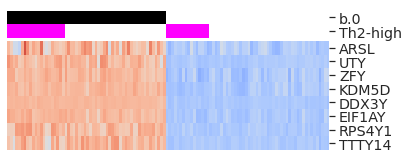

In [43]:
bic_id = 0
genes = sorted(bics1.loc[bic_id,"genes"])
sns_plot,col_order,(row_colors, col_colors) = draw_heatmap2(exprs.loc[genes,:],bics1.loc[[bic_id],:],
                 annot=a.loc[:,["Th2-high"]],
                 color_dict=color_dict,
                 figsize = (6,2.5),dendrogram_ratio=(0.01,0.01),
                 colors_ratio=(0,0.1),
                 no_cbar=True,
                 cluster_rows=True,
                 xlabel = "",
                 col_labels = False,row_labels = True,
                 bic_prefix = "b.")
tmp = sns_plot.ax_heatmap.set_yticklabels(sns_plot.ax_heatmap.get_yticklabels(), rotation=0)
#tmp = sns_plot.fig.suptitle('GSE4302, UnPaSt') 

fig_name = "FigSX_GSE4302_sex_v5"
for ext in ["pdf","svg"]:
    plt.savefig(img_path+"/"+fig_name+"."+ext, dpi=300, transparent=True)

### smoking signarure

AKR1B10 ALDH3A1 BPIFB2 CABYR CYP1A1 CYP1B1 GPX2 HS3ST3A1 JAKMIP3 LINC00942 LINC01697 ME1 NR0B1 NRCAM PHEX SAMD5 SFRP2 SLC7A11 SPP1 UCHL1


<Figure size 432x288 with 0 Axes>

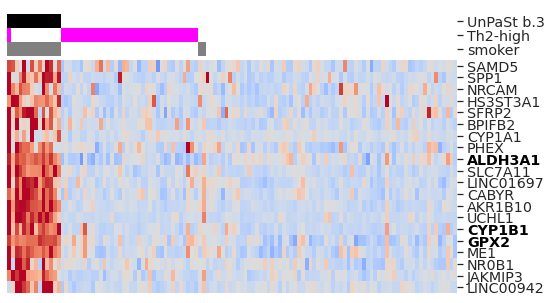

In [44]:
bic_id = 3
genes = sorted(bics1.loc[bic_id,"genes"])
print(" ".join(genes))
plt.figure()
sns_plot,col_order,(row_colors, col_colors) = draw_heatmap2(exprs,
                                                            bics1.loc[[bic_id],:],
                 annot=a.loc[:,["Th2-high","smoker"]],
                 color_dict=color_dict,
                 figsize = (8,4.5),dendrogram_ratio=(0.01,0.01),
                 colors_ratio=(0,0.05),
                 legend_n_cols=0,
                 no_cbar=True,
                 cluster_rows=True,
                 xlabel = "",
                 highlight_row_labels=["ALDH3A1","CYP1B1","GPX2"],
                 col_labels = False,row_labels = True,
                 bic_prefix = "UnPaSt b.")
tmp = sns_plot.ax_heatmap.set_yticklabels(sns_plot.ax_heatmap.get_yticklabels(), rotation=0)
#tmp = sns_plot.fig.suptitle('GSE4302, UnPaSt') 

fig_name = "FigSX_GSE4302_smokers_v5"
for ext in ["pdf","svg"]:
    plt.savefig(img_path+"/"+fig_name+"."+ext, dpi=300, transparent=True)

In [45]:
smoking_signature = sorted(bics1.loc[3,"genes"])
print(" ".join(smoking_signature))
len(smoking_signature)

AKR1B10 ALDH3A1 BPIFB2 CABYR CYP1A1 CYP1B1 GPX2 HS3ST3A1 JAKMIP3 LINC00942 LINC01697 ME1 NR0B1 NRCAM PHEX SAMD5 SFRP2 SLC7A11 SPP1 UCHL1


20

<Figure size 432x288 with 0 Axes>

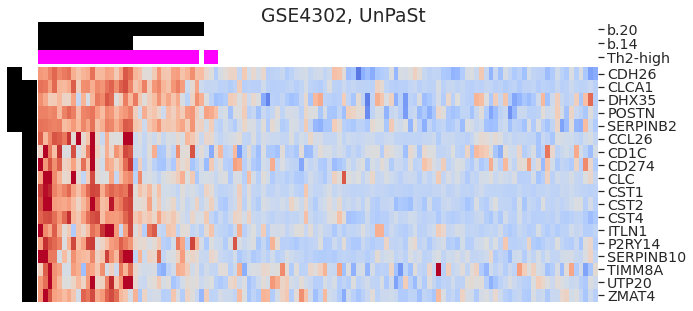

In [46]:
genes = sorted(bics1.loc[14,"genes"]| bics1.loc[20,"genes"])
plt.figure()
sns_plot,col_order,(row_colors, col_colors) = draw_heatmap2(exprs,
                 bics1.loc[[20,14],:],
                 annot=a.loc[:,["Th2-high"]],
                 color_dict=color_dict,
                 figsize = (10,5),dendrogram_ratio=(0.01,0.01),
                 colors_ratio=(0.025,0.05),
                 no_cbar=True,
                 cluster_rows=False,
                 xlabel = "",
                 col_labels = False,row_labels = True,
                 bic_prefix = "b.",
                no_row_colors = False)
tmp = sns_plot.ax_heatmap.set_yticklabels(sns_plot.ax_heatmap.get_yticklabels(), rotation=0)
tmp = sns_plot.ax_row_colors.set_xticklabels([])
tmp = sns_plot.fig.suptitle('GSE4302, UnPaSt') 

fig_name = "FigSX_GSE4302_two_Th2-high"
for ext in ["pdf","svg"]:
    plt.savefig(img_path+"/"+fig_name+"."+ext, dpi=300, transparent=True)

### GSE89809

In [47]:
exprs_file = data_path+"asthma_GSE89809_epithelial.RMA.maxRowVariance.log2exprs.tsv.gz"
exprs = pd.read_csv(exprs_file, sep="\t",index_col=0)

anno  = pd.read_csv(data_path+"asthma_GSE89809_epithelial.annot.tsv.gz",sep="\t",index_col=0)
anno.head(3)
all_samples = set(exprs.columns).intersection(set(anno.index))
bics2 = read_bic_table(bic_path+"GSE89809/UnPaSt/optimized_ARI/asthma_GSE89809.seed=42.kmeans.consensus.biclsuters.tsv")
bics2.head(3)

,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids
id,,,,,,,,,,,,
0,9.687581,39,5,"{GNAS, NOP16, INAVA, PPP1R16A, H3-3B, IDH3G, S...","{GSM2389931, GSM2389890, GSM2389953, GSM238993...",{},"{GNAS, NOP16, INAVA, PPP1R16A, H3-3B, IDH3G, S...","{642, 4486, 7307, 15628, 15118, 14862, 8851, 9...","{10, 43, 44, 49, 27}",DOWN,4,seed=116739_0 seed=26225_0 seed=288389_0 seed=...
1,7.468006,56,5,"{ODF3B, SMARCC2, AHR, NFYB, NSMCE1, PUM2, CLCA...","{GSM2389931, GSM2389953, GSM2389930, GSM238984...",{},"{ODF3B, SMARCC2, AHR, NFYB, NSMCE1, PUM2, CLCA...","{10756, 16263, 9466, 12688, 661, 10262, 791, 1...","{38, 10, 43, 44, 49}",DOWN,3,seed=116739_1 seed=26225_4 seed=670487_1
2,7.383145,15,5,"{ZBED2, RGPD4-AS1, FBN2, IGDCC3, KRTAP4-1, PPP...","{GSM2389931, GSM2389890, GSM2389840, GSM238995...","{ZBED2, RGPD4-AS1, FBN2, IGDCC3, KRTAP4-1, CFA...","{MPZL3, PPP1R2, MOCS2, LRRC34}","{13153, 17571, 7812, 3974, 9863, 9800, 8775, 5...","{1, 10, 44, 49, 27}",BOTH,4,seed=116739_12 seed=26225_19 seed=26225_9 seed...


In [48]:
anno["sex"] = "F"
anno.loc[anno["is_female"]==0,"sex"] = "M"
a = anno.loc[:,["group","Th2 asthma","sex","smoking"]]
a.columns = ["patient group","Th2-high","sex","smoking"]
a.loc[a["patient group"]=="Mild", "patient group"] = "Asthma"
a.loc[a["patient group"]=="Moderate", "patient group"] = "Asthma"
a.loc[a["patient group"]=="Severe", "patient group"] = "Asthma"
a.loc[a["patient group"]=="Healthy", "patient group"] = "Healthy"
a.loc[a["Th2-high"]==1,"Th2-high"] = "Th2-high"
a.loc[a["Th2-high"]==0,"Th2-high"] = "Th2-low"
set(anno["smoking"].values)

{'Current', 'Former', 'Never'}

In [49]:
bics2[bics2["genes"].apply(lambda x: "KDM5D" in x)]

,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids
id,,,,,,,,,,,,
30,3.13724,9,25,"{UTY, DDX3Y, KDM5D, ZNF134, RPS4Y1, EBF4, TSIX...","{GSM2389931, GSM2389889, GSM2389959, GSM238984...","{ZNF134, XIST, TSIX, EBF4}","{UTY, DDX3Y, KDM5D, RPS4Y1, EIF1AY}","{7521, 17795, 4325, 3783, 13544, 16684, 17487,...","{1, 2, 5, 7, 9, 17, 20, 22, 23, 24, 25, 26, 34...",BOTH,8,seed=116739_103 seed=116739_23 seed=26225_26 s...


<Figure size 432x288 with 0 Axes>

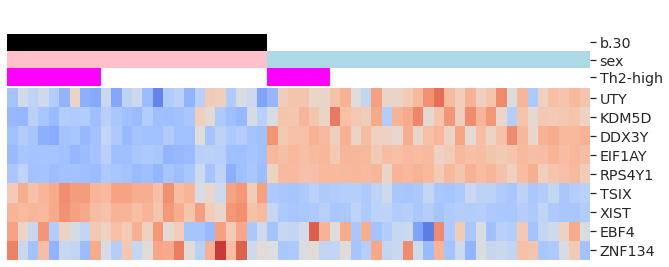

In [50]:
bic_id = 30
genes = sorted(bics2.loc[bic_id,"genes"])
plt.figure()
sns_plot,col_order,(row_colors, col_colors) = draw_heatmap2(zscore(exprs.loc[genes,:]),
                                                            bics2.loc[[bic_id],:],
                 annot=a.loc[:,["sex","Th2-high"]],
                 color_dict=color_dict,
                 figsize = (10,4),dendrogram_ratio=(0.05,0.1),
                 colors_ratio=(0,0.07),
                 #no_legend=False,
                 no_cbar=True,
                 cluster_rows=True,
                 xlabel = "",
                 col_labels = False,row_labels = True,
                 #col_range=(-3,3),
                 bic_prefix = "b.")
tmp = sns_plot.ax_heatmap.set_yticklabels(sns_plot.ax_heatmap.get_yticklabels(), rotation=0)
#tmp = sns_plot.fig.suptitle('GSE89809, UnPaSt') 

fig_name = "FigSX_GSE89809_sex_v5"
for ext in ["pdf","svg"]:
    plt.savefig(img_path+"/"+fig_name+"."+ext, dpi=300, transparent=True)

<Figure size 432x288 with 0 Axes>

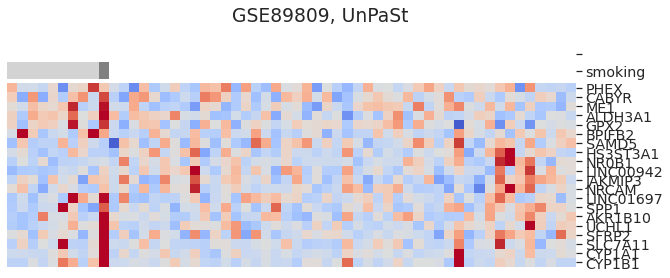

In [51]:
df = {" ":{"genes":set(smoking_signature),
                 "samples":set([]),
                 "genes_up":set(smoking_signature),
                 "genes_down":set([])
                }
     }
df = pd.DataFrame.from_dict(df).T

genes = smoking_signature

plt.figure()
tmp = draw_heatmap2(zscore(exprs.loc[genes,:]),
                    df,
                 annot=a.loc[:,["smoking"]],
                 color_dict=color_dict,
                 figsize = (10,4),dendrogram_ratio=(0.05,0.1),
                 colors_ratio=(0,0.07),
                 no_cbar=True,
                 cluster_rows=True,
                 xlabel = "",
                 col_labels = False,row_labels = True,
                 bic_prefix = "")

tmp = tmp[0].fig.suptitle('GSE89809, UnPaSt') 

fig_name = "FigX_smokingGSE89809A"
plt.savefig(img_path+fig_name+".png", dpi=300)
plt.savefig(img_path+fig_name+".svg")

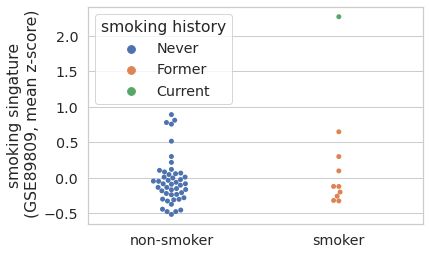

In [52]:
genes = smoking_signature
mean_smoking_z = zscore(exprs.loc[genes,:]).mean()
a = anno.loc[:,["smoking"]]
a.columns = ["smoking history"]
a["smoking singature\n (GSE89809, mean z-score)"] = mean_smoking_z
a["is smoker"] = "smoker"
a.loc[a["smoking history"]=="Never","is smoker"] = "non-smoker"
tmp = sns.swarmplot(data = a, x ="is smoker",
              y ="smoking singature\n (GSE89809, mean z-score)",hue="smoking history")
plt.xlabel("")
sns.set_style("whitegrid")
fig_name = "FigX_smokingGSE89809_swarmplot_v5"
for ext in ["pdf","svg"]:
    plt.savefig(img_path+"/"+fig_name+"."+ext, dpi=300, transparent=True)

In [53]:
mean_smoking_z[a.loc[a["smoking history"]=="Current",:].index.values]

GSM2389957    2.269234
dtype: float64